# Modelo NARMAX

## Metodología
Los pasos a seguir para alcanzar el objetivo son los siguientes:

1. Importación de la base de datos.
2. Análisis de las variables para identificar el tipo de dato.
3. Verificación de valores `NaN` o Nulos.
4. Distribución de las variables.
5. Cálculo de la matriz de correlación.
6. Procesamiento de datos.
7. Resultados y discusión.

## Configuración
### Importación de librerías
Importamos todas las librerías necesarias para trabajar

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_miso_data
from sysidentpy.residues.residues_correlation import (compute_residues_autocorrelation, compute_cross_correlation,)

### Importación de datos
Importamos la base de datos para trabajar el problema de regresión

In [2]:
# 1. Importación de la base de datos
db_ballbeam = pd.read_csv('datasets/ballbeam.csv')
db_ballbeam.head()

,angle,position
0,-0.001963,-0.004885
1,-0.001963,-0.004641
2,-0.001963,-0.003786
3,-0.001963,-0.004030
4,-0.001963,-0.003908


In [3]:
# 2. Análisis de las variables para identificar el tipo de dato
db_ballbeam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   angle     1000 non-null   float64
 1   position  1000 non-null   float64
dtypes: float64(2)
memory usage: 15.8 KB


In [4]:
# 3. Verificación de valores NaN o nulos
db_ballbeam.isnull().sum()

angle       0
position    0
dtype: int64

Text(0.5, 1.0, 'Data of a the ball and beam practicum at ESAT-SISTA')

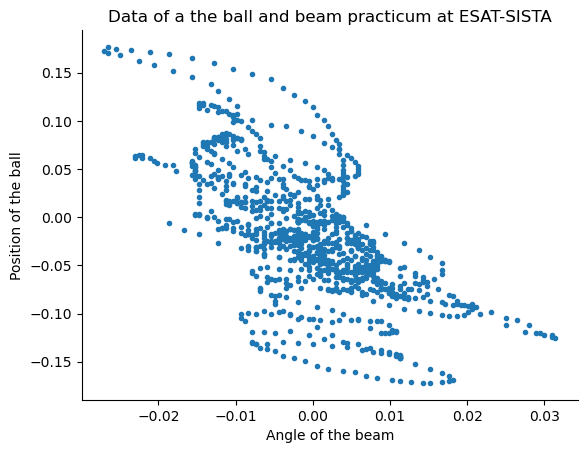

In [5]:
# 6. Procesamiento de datos
# Antes de generar un modelo de regresión lineal debemos representar los datos para observar si existe una relación. 
# Además, dicha relación debe ser cuantificada mediante un coeficiente de correlación
plt.plot(db_ballbeam['angle'], db_ballbeam['position'],'.')
plt.xlabel("Angle of the beam")
plt.ylabel("Position of the ball")
plt.title('Data of a the ball and beam practicum at ESAT-SISTA')

In [8]:
scaler = preprocessing.MinMaxScaler(feature_range = (0.1, 0.9))         

X = scaler.fit_transform(np.array(db_ballbeam['angle']).reshape(-1,1))
y = scaler.fit_transform(np.array(db_ballbeam['position']).reshape(-1,1))

# Libreria para divir el conjunto de datos experimentales en subconjuntos
from sklearn.model_selection import train_test_split

# El tamanio de la prueba especifica la cantidad de datos que desea reservar para el conjunto de prueba.
# El parametro Random_state es solo una semilla aleatoria que podemos usar.
# Puede usarlo si desea reproducir estos resultados especificos.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state = 696)

X_train = np.array(X_train).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 1)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

In [15]:
basis_function = Polynomial(degree = 4)

model = FROLS(order_selection = True,  n_info_values = 3, extended_least_squares = False, ylag = 4, xlag = 10, info_criteria = "aic", estimator = "least_squares", basis_function = basis_function, )

In [16]:
model.fit(X = X_train, y = y_train)
yhat = model.predict(X = X_test, y = y_test)
rrse = root_relative_squared_error(y_test, yhat)
print(rrse)

4.620230314545616


                     Regressors   Parameters             ERR
0                             1   4.9092E-01  8.96501506E-01
1       x1(k-10)x1(k-8)^2y(k-4)  -4.8030E-01  1.06398371E-03
2  x1(k-7)x1(k-6)x1(k-4)x1(k-3)  -4.7516E-01  6.56353610E-04


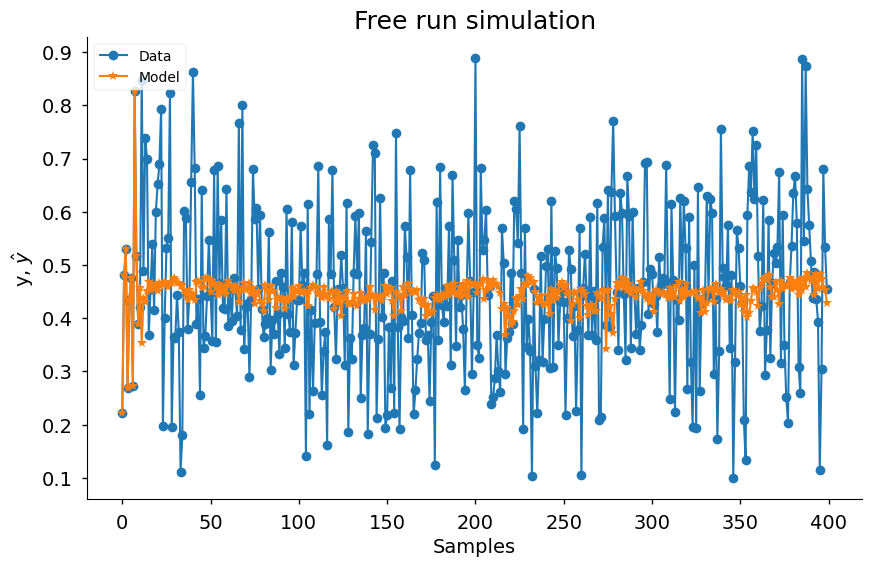

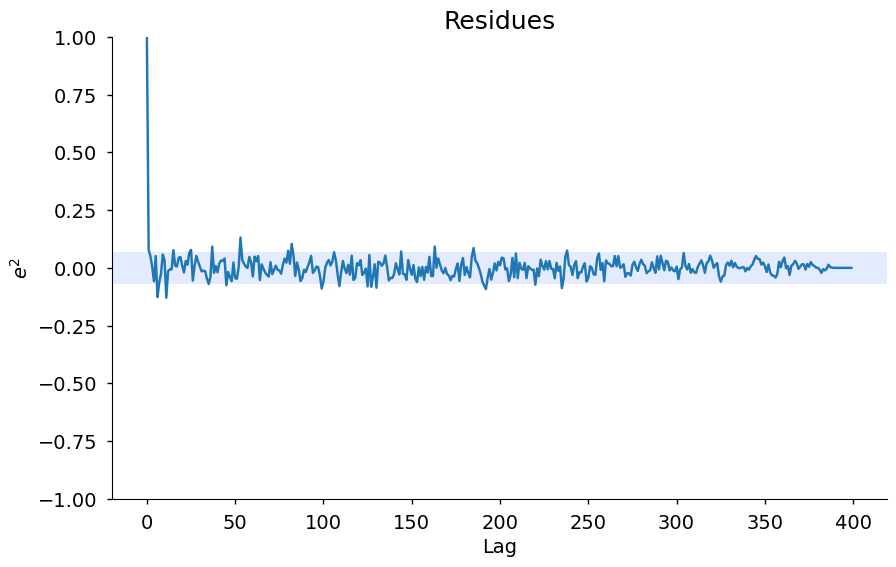

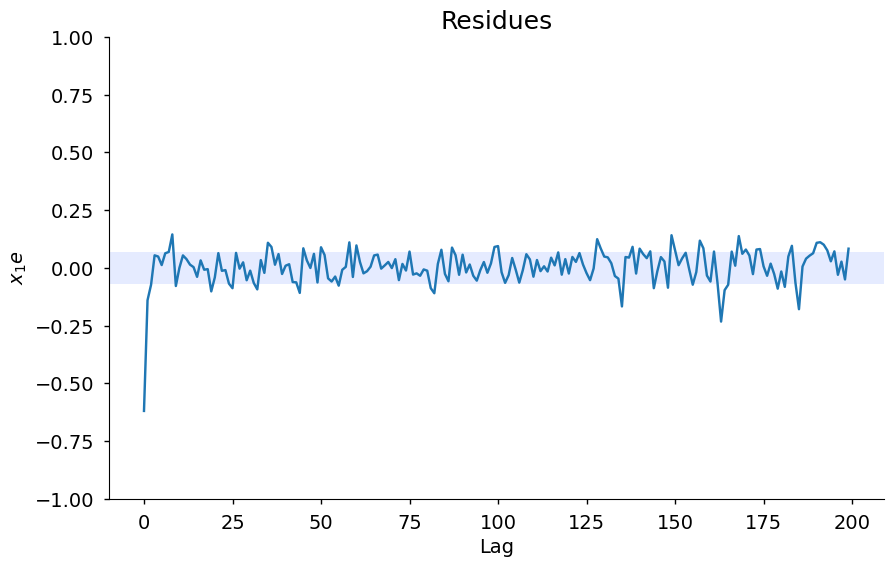

In [17]:
r = pd.DataFrame( results( model.final_model, model.theta, model.err, model.n_terms, err_precision=8, dtype="sci", ), columns=["Regressors", "Parameters", "ERR"], )
print(r) 

plot_results(y = y_test, yhat = yhat, n = 1000, style = "seaborn-v0_8-notebook")
ee = compute_residues_autocorrelation(y_test, yhat)
plot_residues_correlation(data = ee, title = "Residues", ylabel="$e^2$", style = "seaborn-v0_8-notebook")
x1e = compute_cross_correlation(y_test, yhat, X_test[:, 0])
plot_residues_correlation(data = x1e, title = "Residues", ylabel = "$x_1e$", style = "seaborn-v0_8-notebook")

Text(0, 0.5, 'Information Criteria')

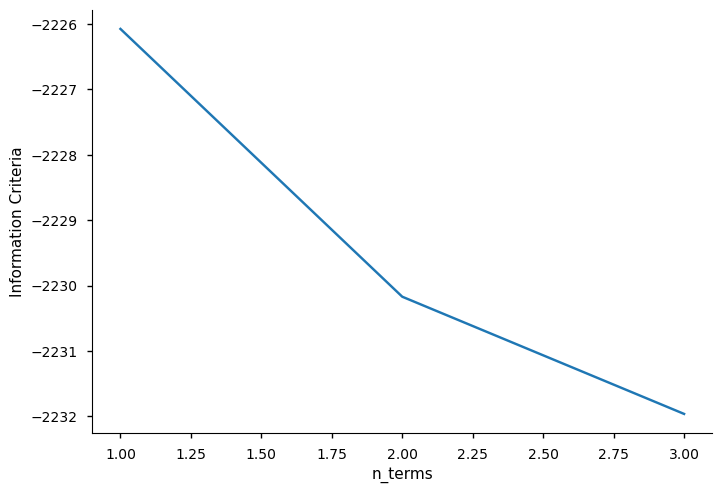

In [18]:
xaxis = np.arange(1, model.n_info_values + 1)
plt.plot(xaxis, model.info_values)
plt.xlabel("n_terms")
plt.ylabel("Information Criteria")